In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from scipy import stats

from sklearn.preprocessing import StandardScaler  

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('586b791c.bewm_data_fixed_3.csv',sep=';')
df.drop(['countrycode','eba71','eba91','i_tier1','i_prob' ,'i_p_prob',
         'h_w1','h_w2','h_w3','h_p_w1','h_p_w2','h_p_w3'],axis=1,inplace=True)
df.fillna(0,inplace=True)
df.reset_index(drop=True,inplace=True)

In [4]:
y_test = df.loc[df.year>=2011]['distressed'].reset_index(drop=True)
X_test = df.loc[df.year>=2011].drop(['quarter','year','bankname','distressed'],axis=1).reset_index(drop=True)
y_train = df.loc[df.year<2011]['distressed'].reset_index(drop=True)
X_train = df.loc[df.year<2011].drop(['quarter','year','bankname','distressed'],axis=1).reset_index(drop=True)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [5]:
list_t = []
list_prob = []
for i in range(4,df.shape[1]):
    group1 = df.where(df.distressed== 1).dropna().iloc[:,i]
    group0 = df.where(df.distressed== 0).dropna().iloc[:,i]
    list_t.append(stats.ttest_ind(group0,group1)[0])
    list_prob.append(stats.ttest_ind(group0,group1)[1])

In [6]:
comp_stat = df.groupby('distressed').apply(pd.DataFrame.describe).transpose()[[0,1]].iloc[3:,[1,2,9,10]]
comp_stat['t'] = list_t
comp_stat['Prob'] = list_prob
comp_stat.index = ['Capital ratio','Impaired assets','Reserves to impaired assets','Loan loss provisions','ROA','ROE',
                  'Cost to income','Net interest margin','Interest expenses to liabilities','Net-short term borrowing','Deposits to funding',
                  'Share of trading income','Total assets to GDP','Non-core liabilities','Debt to equity','Loans to deposits',
                  'Debt securities to liabilities','Mortgages to loans','Real GDP','Inflation','Stock prices',
                   'Long-term government bond yield','House prices','International investment position to GDP',
                   'Government debt to GDP','Private sector credit flow to GDP']

In [7]:
comp_stat.round(2)

distressed                                 0.0         1.0            t  Prob
                                          mean   std  mean   std             
Capital ratio                             0.02  0.74 -0.40  0.58  13.14  0.00
Impaired assets                          -0.00  0.98 -0.01  0.84   0.20  0.84
Reserves to impaired assets              -0.02  0.89 -0.11  0.94   2.25  0.02
Loan loss provisions                      0.02  0.86  0.13  0.81  -2.96  0.00
ROA                                       0.05  0.90 -0.13  1.02   4.48  0.00
ROE                                       0.02  0.99  0.06  1.18  -0.82  0.41
Cost to income                            0.00  0.93 -0.02  0.81   0.48  0.63
Net interest margin                       0.11  0.85 -0.03  1.03   3.66  0.00
Interest expenses to liabilities         -0.17  0.83  0.23  0.98 -11.03  0.00
Net-short term borrowing                  0.05  0.91  0.15  0.80  -2.53  0.01
Deposits to funding                      -0.02  0.86 -0.01  0.89  -0.36  0.72
Share of trading income                   0.01  0.97  0.05  1.05  -0.88  0.38
Total assets to GDP                      -0.12  0.37  0.10  0.56 -12.94  0.00
Non-core liabilities                     -0.03  1.06  0.21  1.06  -5.19  0.00
Debt to equity                           -0.33  0.83  0.04  0.85 -10.02  0.00
Loans to deposits                        -0.11  0.91  0.01  1.39  -2.86  0.00
Debt securities to liabilities           -0.04  0.96 -0.29  1.20   5.69  0.00
Mortgages to loans                        0.15  1.03  0.47  0.99  -7.11  0.00
Real GDP                                 -0.12  0.98 -0.43  1.30   7.26  0.00
Inflation                                -0.04  0.86  0.06  1.23  -2.56  0.01
Stock prices                             -0.03  0.96 -0.21  1.04   4.26  0.00
Long-term government bond yield           0.02  1.11  0.23  1.57  -4.32  0.00
House prices                             -0.01  1.07 -0.29  0.62   6.07  0.00
International investment position to GDP -0.24  0.95 -0.69  1.27  10.69  0.00
Government debt to GDP                    0.16  1.04 -0.20  1.11   7.93  0.00
Private sector credit flow to GDP        -0.06  0.85  0.65  1.10 -18.57  0.00

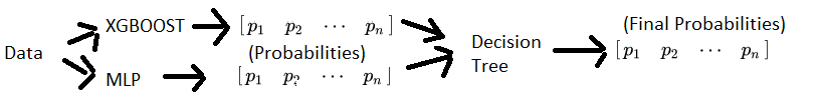

In [8]:
from IPython.display import Image
Image("hybrid.PNG")

In [9]:
#########
#Modelling

In [10]:
##Logistic Regression
#Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(random_state=123,max_iter=1000,solver='lbfgs')

logreg_cv = GridSearchCV(logreg, param_grid = {'penalty' : ['none']},scoring='roc_auc',
                          cv = 5)

logreg_cv.fit(X_train, y_train)
print("AUROC on cross-validadtion: {}".format(logreg_cv.best_score_))

AUROC on cross-validadtion: 0.7527291013946591


In [11]:
###XGB
#Instantiate a gradient boosting
xgb_m = xgb.XGBClassifier(random_state=123)

#                                          {'eta' : [0.1,0.2,0.3],
#                                          'n_estimators':[50,100,200,300],
#                                          'max_depth':[2,5,10,15,20,30],
#                                          'gamma':[0,0.2,0.5],
#                                          'lambda':[1,1.2,1.5],
#                                          'alpha':[0,0.2,0.5,0.8]},

#alpha=0.5, eta=0.2, gamma=0, lambda=1, max_depth=10, n_estimators=100,
xgb_cv = GridSearchCV(xgb_m, param_grid = {'alpha': [0.5],
                                                 'eta': [0.2],
                                                 'gamma': [0],
                                                 'lambda': [1],
                                                 'max_depth': [10],
                                                 'n_estimators': [100]},
                                 scoring='roc_auc',n_jobs=-1,cv = 5)

# Compute accuracy on test set
xgb_cv.fit(X_train, y_train)
print("AUROC on cross-validadtion: {}".format(xgb_cv.best_score_))

[17:55:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUROC on cross-validadtion: 0.860624087965346


In [12]:
###Multilayer perceptron
#Instantiate a MLP
mlp = MLPClassifier(random_state=123)

#mlp_cv = GridSearchCV(mlp, param_grid = {'hidden_layer_sizes':[(100,50,),(200,),(2,),(3,),(5,),(7,),(10,),
#                                                              (5,5,),(10,5,),(30,20,10,)],
#                                         'max_iter': [600],
#                                         'alpha': [0.0001,0.001,0.01,0.1,0.5],
#                                        'activation': ['relu','identity', 'tanh','logistic']},
#                                 scoring='roc_auc',n_jobs=-1,cv = 5)

mlp_cv = GridSearchCV(mlp, param_grid = {'hidden_layer_sizes':[(10,)],
                                        'activation': ['tanh'],
                                         'alpha': [0.5],
                                         'learning_rate': ['constant'],
                                        'max_iter': [600]},
                                 scoring='roc_auc',n_jobs=-1,cv = 5)

mlp_cv.fit(X_train, y_train)
print("AUROC on cross-validadtion: {}".format(mlp_cv.best_score_))

AUROC on cross-validadtion: 0.849281261292419


In [13]:
######
#ensemble
d = {'xgb':xgb_cv.predict_proba(X_train)[:,1], 'mlp':mlp_cv.predict_proba(X_train)[:,1]}
X_train_ensemble = pd.DataFrame(d)
d_test = {'xgb':xgb_cv.predict_proba(X_test)[:,1], 'mlp':mlp_cv.predict_proba(X_test)[:,1]}
X_test_ensemble = pd.DataFrame(d_test)

In [14]:
X_train_ensemble.head()

,xgb,mlp
0,0.000055,0.001344
1,0.000073,0.001615
2,0.000097,0.001747
3,0.000167,0.003333
4,0.000228,0.001702


In [15]:
clf = DecisionTreeClassifier(random_state=123)

clf_cv = GridSearchCV(clf, param_grid = {'splitter' : ['random','best'],
                        'max_depth' : [2,3,4,5,10,15,20],
                      'max_features' : [2]},
                      scoring='roc_auc',
                          cv = 5)

clf_cv.fit(X_train_enemble, y_train)
print("AUROC on cross-validadtion: {}".format(clf_cv.best_score_))

AUROC on cross-validadtion: 1.0


In [16]:
from sklearn.tree import export_graphviz
tree_structure = export_graphviz( 
 clf_cv.best_estimator_,
 out_file=None,
 feature_names=['xgb','mlp'],
 class_names=None,
 filled=True,
)
print(tree_structure)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="xgb <= 0.221\ngini = 0.12\nsamples = 8122\nvalue = [7603, 519]", fillcolor="#e78a47"] ;
1 [label="gini = 0.0\nsamples = 7603\nvalue = [7603, 0]", fillcolor="#e58139"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.0\nsamples = 519\nvalue = [0, 519]", fillcolor="#399de5"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}


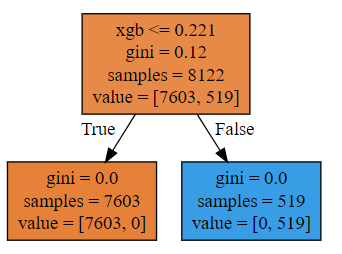

In [17]:
Image("dt_plt.PNG")

In [18]:
#creating dataframe for results
results_df = pd.DataFrame({'LOGIT': [0, 0], 'XGBOOST': [0, 0],'MLP': [0, 0],'HYBRID': [0, 0]},
                          index=["Cross-Validation","Test"])
results_df['LOGIT'] = [logreg_cv.best_score_,roc_auc_score(y_test, logreg_cv.predict_proba(X_test)[:,1])]
results_df['XGBOOST'] = [xgb_cv.best_score_,roc_auc_score(y_test, xgb_cv.predict_proba(X_test)[:,1])]
results_df['MLP'] = [mlp_cv.best_score_,roc_auc_score(y_test, mlp_cv.predict_proba(X_test)[:,1])]
results_df['HYBRID'] = [clf_cv.best_score_,roc_auc_score(y_test, clf_cv.predict_proba(X_test_ensemble)[:,1])]

In [19]:
results_df.round(3).transpose().sort_values('Cross-Validation',ascending=False)

,Cross-Validation,Test
HYBRID,1.000,0.776
XGBOOST,0.861,0.966
MLP,0.849,0.908
LOGIT,0.753,0.828


In [20]:
list_f1 = []
list_recall = []
list_precision = []

for i in np.arange(0.05,0.7,0.05):
    list_f1.append(f1_score(y_test,logreg_cv.predict_proba(X_test)[:,1]>i))
    list_recall.append(recall_score(y_test,logreg_cv.predict_proba(X_test)[:,1]>i))
    list_precision.append(precision_score(y_test,logreg_cv.predict_proba(X_test)[:,1]>i))
for i in np.arange(0.05,0.7,0.05):
    list_f1.append(f1_score(y_test,clf_cv.predict_proba(X_test_ensemble)[:,1]>i))
    list_recall.append(recall_score(y_test,clf_cv.predict_proba(X_test_ensemble)[:,1]>i))
    list_precision.append(precision_score(y_test,clf_cv.predict_proba(X_test_ensemble)[:,1]>i))
for i in np.arange(0.05,0.7,0.05):
    list_f1.append(f1_score(y_test,xgb_cv.predict_proba(X_test)[:,1]>i))
    list_recall.append(recall_score(y_test,xgb_cv.predict_proba(X_test)[:,1]>i))
    list_precision.append(precision_score(y_test,xgb_cv.predict_proba(X_test)[:,1]>i))

In [21]:
df = pd.DataFrame({
    'model' : np.repeat(['LOGIT','HYBRID','XGB'],13),
    'cut-off' : np.round(list(np.arange(0.05,0.7,0.05)) *3,3),
    'f1' : np.round(list_f1,3),
    'recall' : np.round(list_recall,3),
    'precision' : np.round(list_precision,3)
})
df_multi = df.set_index(['cut-off','model']).stack().unstack([1,2])

In [22]:
zz = lambda s: np.where(df_multi.columns.get_level_values(0).isin(["LOGIT"]), "color:cornflowerblue;", np.where(df_multi.columns.get_level_values(0).isin(["HYBRID"]), "color:indianred;", "color:black;"))
df_multi.style.set_properties(**{'font-weight': 'bold'}).apply(zz, axis=1).format("{:.3f}")

In [23]:
cf0 = confusion_matrix(y_test,logreg_cv.predict_proba(X_test)[:,1]>0.1)
cf1 = confusion_matrix(y_test,clf_cv.predict_proba(X_test_ensemble)[:,1]>0.5)
cf2 = confusion_matrix(y_test,xgb_cv.predict_proba(X_test)[:,1]>0.35)
cf3 = confusion_matrix(y_test,xgb_cv.predict_proba(X_test)[:,1]>0.01)

Text(0.5, 1.0, 'XGB; cutoff = 0.01')

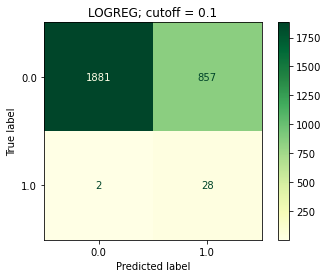

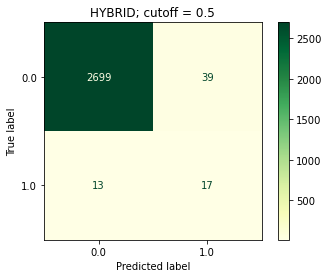

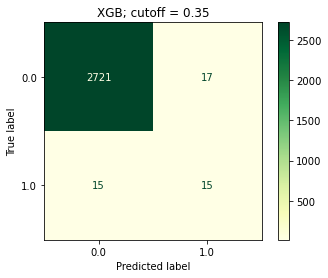

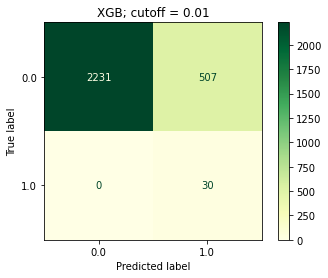

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=cf0,
                              display_labels=logreg_cv.classes_)
disp.plot(cmap='YlGn')
disp.ax_.set_title("LOGREG; cutoff = 0.1")
disp = ConfusionMatrixDisplay(confusion_matrix=cf1,
                              display_labels=logreg_cv.classes_)
disp.plot(cmap='YlGn')
disp.ax_.set_title("HYBRID; cutoff = 0.5")
disp = ConfusionMatrixDisplay(confusion_matrix=cf2,
                              display_labels=logreg_cv.classes_)
disp.plot(cmap='YlGn')
disp.ax_.set_title("XGB; cutoff = 0.35")
disp = ConfusionMatrixDisplay(confusion_matrix=cf3,
                              display_labels=logreg_cv.classes_)
disp.plot(cmap='YlGn')
disp.ax_.set_title("XGB; cutoff = 0.01")